# **PROGETTO DSIM:** *Speech emotion recognition*

Mario Pedol (830296),

il task di questo progetto è quello di provare a riconoscere il tipo di espressione partendo da dei file audio. Il dataset a cui si fa rifermento è preso da kaggle al seguente link: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/data.

A questo fine si sono implementate tecniche diverse di ML e DL supervisionato, presenti e commentate nel presente notebook.





## Set Up envarioment

Caricamento librerie per la gestione dei dati audio:

In [ ]:
import pandas as pd
import librosa
import numpy as np
import pickle
from shutil import copyfile
from google.colab import drive
import os
import librosa.display
from librosa.display import specshow
import IPython.display as ipd
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import soundfile as sf
import shutil
import cv2
import seaborn as sns

Caricamento librerie per task di classificazione subervisionata con tecniche di ML classico:

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

Caricamento librerie per task di classificazione subervisionata con tecniche di transfer learning:

In [ ]:
# Deep learning
import tensorflow as tf
from tensorflow import keras
import keras
from keras.models import load_model
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical, get_source_inputs
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

Set up del path e directory per il caricamento, salvataggio e gestione dei dati e modelli:

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
path='gdrive/MyDrive/Progetto_DSIM/dati/AudioWAV'


## Data Exploration

Si crea una funzione utils per estrarre le label dalla cartella audio, rapresentanti le varie emozioni:



*   Angry
*   Disgust
* Fear
* Happy
* Neutral
* Sad



In [ ]:
def get_label(file_name):
    ele = file_name[9:12]
    if ele=='ANG':
        return 'angry'
    elif ele=='DIS':
        return 'disgust'
    elif ele=='FEA':
        return 'fear'
    elif ele=='HAP':
        return 'happy'
    elif ele=='NEU':
        return 'neutral'
    elif ele=='SAD':
        return 'sad'
    else:
        return'surprise'

Si costruisce il data set per una prima esplorazione dei dati:

In [ ]:
file_emotion = []
file_path = []

for file in sorted(os.listdir(path)):
    file_path.append(file)
    file_emotion.append(get_label(file))
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data = pd.concat([emotion_df, path_df], axis=1)
data.head()

,Emotions,Path
0,angry,1001_DFA_ANG_XX.wav
1,disgust,1001_DFA_DIS_XX.wav
2,fear,1001_DFA_FEA_XX.wav
3,happy,1001_DFA_HAP_XX.wav
4,neutral,1001_DFA_NEU_XX.wav


In [ ]:
data.shape

(7442, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


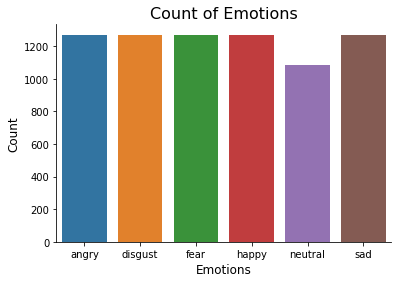

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show();

Come si osserva dal grafico ci sono 7442 audio, con una ditrbuzione piuttosto uniforme di circa 1300 audio per emozione.

Una nota che è utile far notare, sono le varità di attori che pronuciano le frasi. Inoltre, questi hanno tutti una lunghezza differente, compresa tra 1.5 e 3 sec. Un esempio di audio si può ascoltare qui sotto:

In [ ]:
audio=np.array(data['Path'])
ipd.Audio(path+str('/')+audio[1000])

Si plotta ora per ogni emozione il waveplot (Frequenza, Tempo):

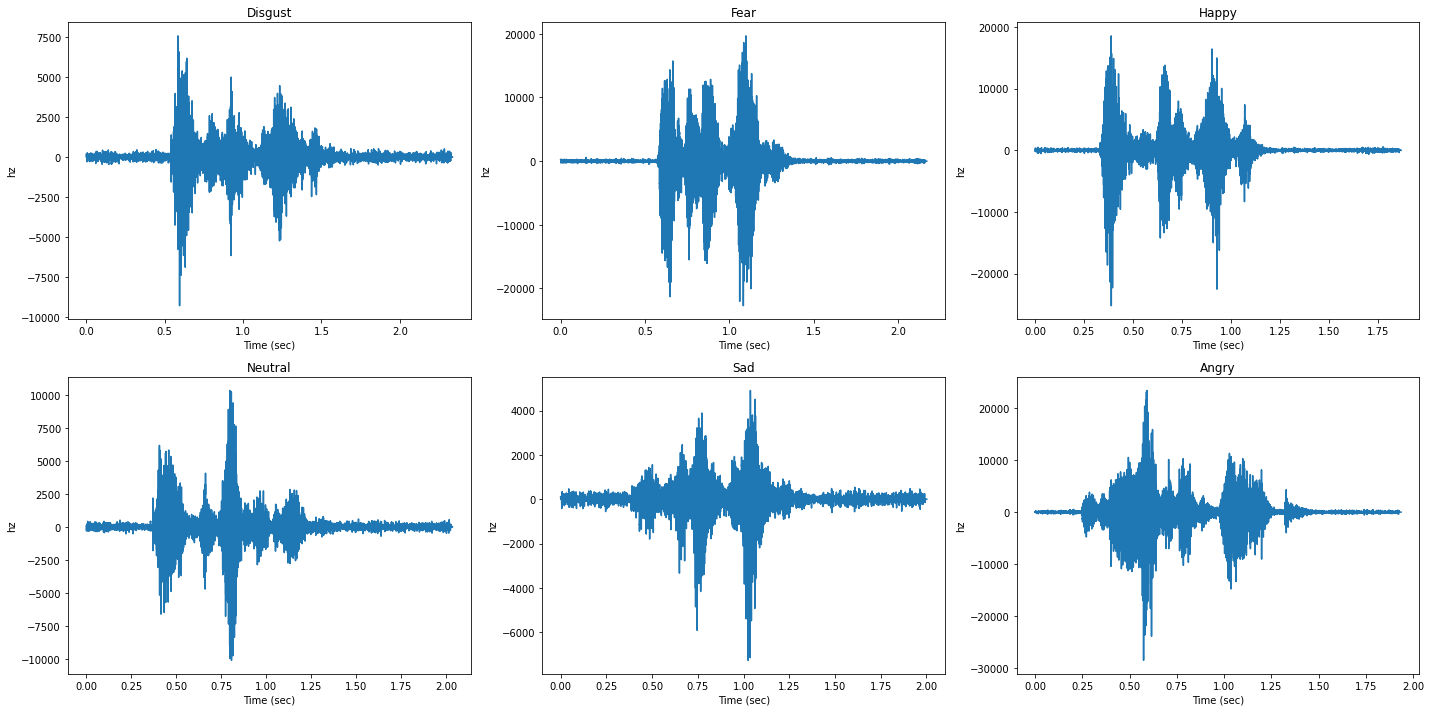

In [ ]:
rate, signal = wav.read(path+str('/')+audio[1])
rate2, signal2 = wav.read(path+str('/')+audio[2])
rate3, signal3 = wav.read(path+str('/')+audio[3])
rate4, signal4 = wav.read(path+str('/')+audio[4])
rate5, signal5 = wav.read(path+str('/')+audio[5])
rate6, signal6 = wav.read(path+str('/')+audio[6])

signal=signal.astype(float)
signal2=signal2.astype(float)
signal3=signal3.astype(float)
signal4=signal4.astype(float)
signal5=signal5.astype(float)
signal6=signal6.astype(float)

fig, axs = plt.subplots(2, 3, figsize=(20,10))
axs[0, 0].plot(np.arange(signal.shape[0]) / rate, signal)
axs[0, 0].set_title("Disgust")
axs[0, 1].plot(np.arange(signal2.shape[0]) / rate2, signal2)
axs[0, 1].set_title("Fear")
axs[0, 2].plot(np.arange(signal3.shape[0]) / rate3, signal3)
axs[0, 2].set_title("Happy")
axs[1, 0].plot(np.arange(signal4.shape[0]) / rate4, signal4)
axs[1, 0].set_title("Neutral")
axs[1, 1].plot(np.arange(signal5.shape[0]) / rate5, signal5)
axs[1, 1].set_title("Sad")
axs[1, 2].plot(np.arange(signal6.shape[0]) / rate6, signal6)
axs[1, 2].set_title("Angry")

for ax in axs.flat:
    ax.set(xlabel='Time (sec)', ylabel='hz')
fig.tight_layout()

Cioò che si può notare è come un pò tutti i grafici siano simili all'emozione "Neutral", di fatto di potrebbe dire che le varie emozioni sono delle particolarità (frequenze più basse o più alte in un punto) di "Neutral".

Si visualizzano ora i vari spettogrammi per emozione:

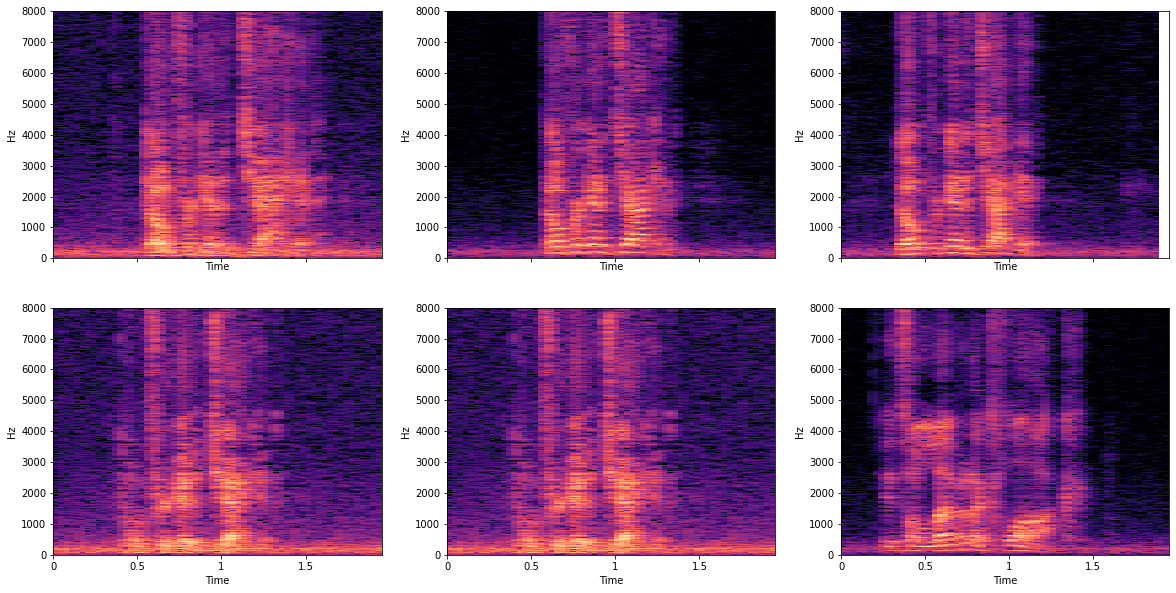

In [ ]:
sig_stft = librosa.stft(signal)
sig_db = librosa.amplitude_to_db(abs(sig_stft))

sig_stft1 = librosa.stft(signal2)
sig_db1 = librosa.amplitude_to_db(abs(sig_stft1))

sig_stft2 = librosa.stft(signal3)
sig_db2 = librosa.amplitude_to_db(abs(sig_stft2))

sig_stft3 = librosa.stft(signal4)
sig_db3 = librosa.amplitude_to_db(abs(sig_stft3))

sig_stft4 = librosa.stft(signal5)
sig_db4 = librosa.amplitude_to_db(abs(sig_stft4))

sig_stft5 = librosa.stft(signal5)
sig_db5 = librosa.amplitude_to_db(abs(sig_stft5))

sig_stft6 = librosa.stft(signal6)
sig_db6 = librosa.amplitude_to_db(abs(sig_stft6))




fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True,figsize=(20,10))

librosa.display.specshow(sig_db, sr=rate, x_axis='time', y_axis='hz', ax=ax[0, 0]) # mfcc in row i, column 1
librosa.display.specshow(sig_db1, sr=rate2, x_axis='time', y_axis='hz', ax=ax[0, 1])
librosa.display.specshow(sig_db2, sr=rate3, x_axis='time', y_axis='hz', ax=ax[0, 2])
librosa.display.specshow(sig_db4, sr=rate4, x_axis='time', y_axis='hz', ax=ax[1, 0])  # spectrogram in row i, column 2
librosa.display.specshow(sig_db5, sr=rate5, x_axis='time', y_axis='hz', ax=ax[1, 1])
librosa.display.specshow(sig_db6, sr=rate6, x_axis='time', y_axis='hz', ax=ax[1, 2])

# Approccio Supervised ML classico

Per afforntare il task sopra proposto, come primo approccio si ricorre a una tecnica di ML supervisionado estraendo le varie feature in maniera *handcrafted*. In partiocolare, vengono estratte dai segnali le seguenti informazioni mediante la libreria librosa:

- Zero Corssing Rate: tasso di cambio di segno del segnale durante la durata di un particolare frame;
- Chroma_stft;
- Mfcc:coefficienti cepstrali di frequenza formano una rappresentazione cepstrale in cui le bande di frequenza non sono lineari ma distribuite secondo la scala mel;
- rms: root mean square value.


## Data Preprocessing

Si definisce una funzione di estrazione delle feature dai segnali audio:

In [ ]:
# Feature extractor da costruire con le variabile che ci vengono in mente
def feature_extractor(signal,rate):

    result = np.array([])

    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    stft = np.abs(librosa.stft(signal))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    rms = np.mean(librosa.feature.rms(y=signal).T, axis=0)
    result = np.hstack((result, rms))
     

    return result


si definisce la funzione di caricamento:

In [ ]:
def load_data(path):

    labels = []
    X = []

    for f in sorted(os.listdir(path)):
        if f.endswith('.wav'):
          try:
            signal,rate = librosa.load(path+str('/')+f, duration=2.5, offset=0.6)
            X.append(feature_extractor(signal,rate))
            # feat=get_features(signal,rate)
            # for ele in feat:
            #     X.append(ele)            
            labels.append(get_label(f))
            
          except:
            print(f)
            
    FinalData = pd.DataFrame(X)
    FinalData['labels'] = labels
    return FinalData


Si forma il Dateset applicando le funzioni precedentemente definite:

In [ ]:
FinalData=load_data(path) #7min 30sec 

Il dataset finale che si ottiene è corente con le dimensioni del dataset orginale (7442 file), ma con tutte le feature numeriche estratte (34+target):

In [ ]:
FinalData.shape, data.shape 

((7442, 35), (7442, 2))

In [ ]:
FinalData.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,labels
0,0.101868,0.661535,0.698241,0.688564,0.677219,0.649148,0.573314,0.581745,0.635928,0.666478,...,-6.133845,1.729553,-14.572468,-5.177709,-2.441027,-8.687389,-6.905550,-7.075168,1376.727488,angry
1,0.093061,0.718796,0.739444,0.659150,0.664364,0.690202,0.616338,0.582933,0.600343,0.668986,...,-6.139793,-3.581317,-12.686419,-3.141734,-3.569355,-8.550379,-7.985445,-3.877425,525.243638,disgust
2,0.084286,0.630143,0.671622,0.649829,0.658581,0.611804,0.594643,0.606432,0.673417,0.690895,...,-6.507923,-2.646703,-11.702737,-5.782084,-4.974335,-8.039696,-7.912496,-5.976987,1501.132523,fear
3,0.084878,0.636740,0.666682,0.671310,0.680510,0.662917,0.657888,0.580282,0.593403,0.638879,...,-9.341311,-0.540506,-13.181042,-5.567631,-3.182104,-8.340280,-6.288166,-3.246957,1388.284575,happy
4,0.082031,0.707973,0.680460,0.669262,0.673300,0.642117,0.582142,0.596400,0.643565,0.676811,...,-3.449930,0.410337,-12.451499,-4.633279,-4.424873,-5.467870,-7.411236,-5.758868,671.999689,neutral


Si salvano i dati ottenuti nella cartella dati del progetto:

In [ ]:
FinalData.to_csv('FinalData.csv', index=False)

In [ ]:
!cp FinalData.csv '/content/gdrive/MyDrive/Progetto_DSIM/dati/FinalData.csv'

## Data Preparation

In questa fase si preparano i dati affinché per l'addestramento dei vari modelli:

In [ ]:
FinalData=pd.read_csv('gdrive/MyDrive/Progetto_DSIM/dati/FinalDataV1.csv')

In [ ]:
FinalData.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,labels
0,0.085128,0.671304,0.697488,0.676313,0.669976,0.669712,0.577660,0.577772,0.644556,0.652684,...,-1.559784,-16.505135,10.678276,-14.308767,-5.582510,-3.648744,-0.867006,-9.322705,0.036065,angry
1,0.078132,0.718978,0.730493,0.655114,0.667761,0.688491,0.603927,0.578656,0.619608,0.682274,...,1.021081,-14.465546,7.405124,-17.794363,-1.290640,-5.278301,-1.755568,-9.588642,0.018096,disgust
2,0.070830,0.577646,0.608404,0.630609,0.656565,0.616906,0.573222,0.554951,0.632575,0.668919,...,-1.929932,-13.079965,5.288561,-13.178360,-4.960666,-5.067886,-2.750220,-9.111576,0.058349,fear
3,0.069238,0.666779,0.679721,0.703939,0.674971,0.660148,0.633040,0.583252,0.572267,0.677920,...,-0.929482,-17.896330,5.809688,-14.164128,-5.773639,-4.838142,-2.735688,-9.291549,0.037393,happy
4,0.064138,0.695003,0.673649,0.656708,0.677206,0.649931,0.585246,0.602071,0.643529,0.695940,...,-1.880345,-10.717338,7.540869,-12.311503,-7.806875,-4.080359,-2.682745,-5.256252,0.018984,neutral


Split dei dati in train e validation set e standardizzazione delle feature mediante StandardScaler. Le dimensioni di validation e train sono indicate in seguito:

In [ ]:
X = FinalData.iloc[: ,:-1].values
Y = FinalData['labels'].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5581, 34), (5581,), (1861, 34), (1861,))

## Modeling

In questa sezione sono stati addestrati e testati diversi modelli con parmetri ottimizati:

In [ ]:
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0],
          'kernel':['rbf', 'sigmoid']}
# Support Vector Machine initialization
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=2)

In [ ]:
clf = clf.fit(x_train, y_train)

In [ ]:
clf.best_params_

{'C': 100.0, 'gamma': 0.005, 'kernel': 'rbf'}

In [ ]:
y_pred = clf.predict(x_test)

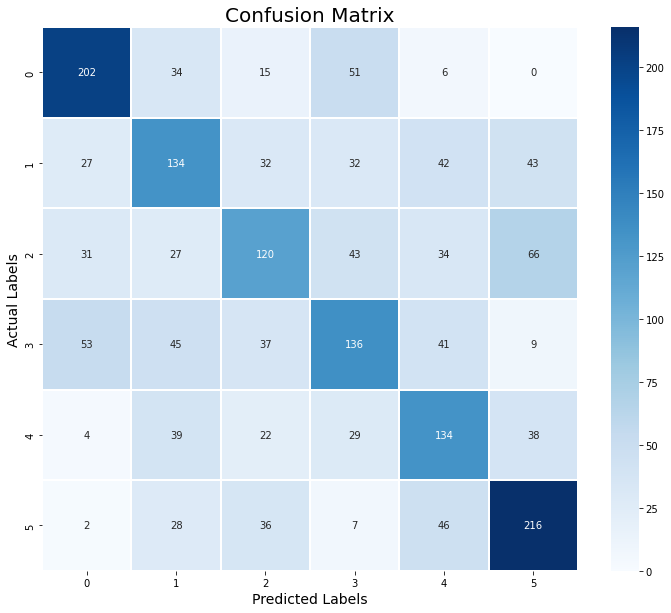

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
names=list((pd.DataFrame(Y)[0]).unique())

In [ ]:
cl = classification_report(y_test, y_pred, target_names = names) 
print('\nClassification Report\n', cl)
print('\n')

# base - 51% acc
# prof feat - 47%


Classification Report
               precision    recall  f1-score   support

       angry       0.63      0.66      0.64       308
     disgust       0.44      0.43      0.43       310
        fear       0.46      0.37      0.41       321
       happy       0.46      0.42      0.44       321
     neutral       0.44      0.50      0.47       266
         sad       0.58      0.64      0.61       335

    accuracy                           0.51      1861
   macro avg       0.50      0.51      0.50      1861
weighted avg       0.50      0.51      0.50      1861





Dal clasification Report si ha un accuracy pari al 51%. Guardando la confusion matrix si può notare come le classi che sono state predette meglio sono i due estremi, "Angry" e "Sad", questo può essere dovuto al fatto di avere feature che meglio si differenziano dalle altre classi.

In [ ]:
param_grid={ 'bootstrap':[True, False],
    'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

rf = RandomizedSearchCV( RandomForestClassifier(random_state = 42), param_grid, cv=2, n_jobs=-1)

In [ ]:
rf = rf.fit(x_train, y_train)

In [ ]:
rf.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [ ]:
y_pred = rf.predict(x_test)

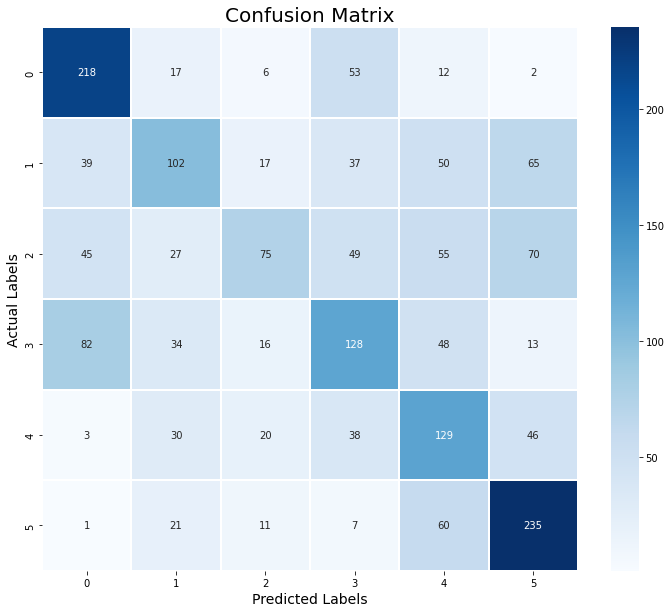

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
cl = classification_report(y_test, y_pred, target_names = names) 
print('\nClassification Report\n', cl)
print('\n')


Classification Report
               precision    recall  f1-score   support

       angry       0.56      0.71      0.63       308
     disgust       0.44      0.33      0.38       310
        fear       0.52      0.23      0.32       321
       happy       0.41      0.40      0.40       321
     neutral       0.36      0.48      0.42       266
         sad       0.55      0.70      0.61       335

    accuracy                           0.48      1861
   macro avg       0.47      0.48      0.46      1861
weighted avg       0.48      0.48      0.46      1861





Dal clasification Report si ha un accuracy pari al 48%. Guardando la confusion matrix si può notare come nel precedente modello che le classi "Angry" e "Sad" risultano meglio classificate.

In [ ]:
space={'max_depth': [3, 18, 1],
        'gamma': [1,9],
        'reg_alpha' : [40,180,1],
        'reg_lambda' : [ 0,1],
        'colsample_bytree' : [0.5,1],
        'min_child_weight' : [ 0, 10, 1],
        'n_estimators': [100,180,200]
    }

In [ ]:
xb = RandomizedSearchCV( xgb.XGBClassifier(), space, cv=3, n_jobs=-1)
xb.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 1],
                                        'gamma': [1, 9],
                                        'max_depth': [3, 18, 1],
                                        'min_child_weight': [0, 10, 1],
                                        'n_estimators': [100, 180, 200],
                                        'reg_alpha': [40, 180, 1],
                                        'reg_lambda': [0, 1]})

In [ ]:
xb.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'max_depth': 18,
 'min_child_weight': 0,
 'n_estimators': 200,
 'reg_alpha': 1,
 'reg_lambda': 1}

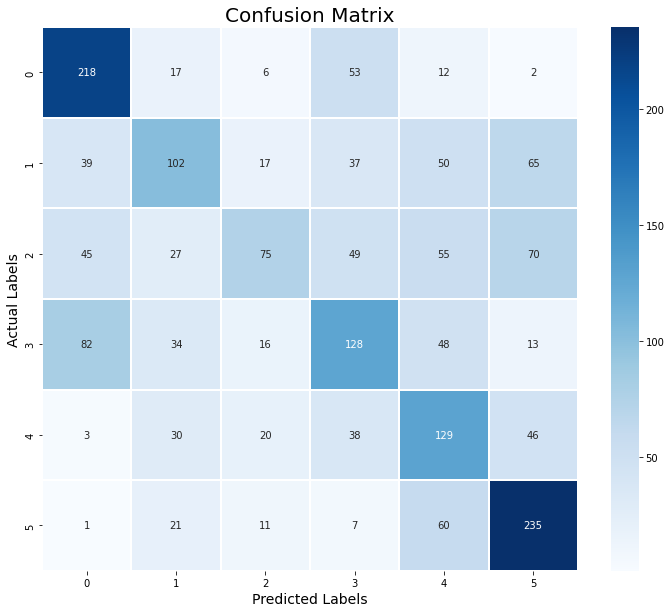

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
cl = classification_report(y_test, y_pred, target_names = names) 
print('\nClassification Report\n', cl)
print('\n')


Classification Report
               precision    recall  f1-score   support

       angry       0.56      0.71      0.63       308
     disgust       0.44      0.33      0.38       310
        fear       0.52      0.23      0.32       321
       happy       0.41      0.40      0.40       321
     neutral       0.36      0.48      0.42       266
         sad       0.55      0.70      0.61       335

    accuracy                           0.48      1861
   macro avg       0.47      0.48      0.46      1861
weighted avg       0.48      0.48      0.46      1861





Come si legge dai risultati il modello non migliora rispetto a quelli addestrati in precedenza.

#### Model Saved

Si salva il modello che ha ottenuto le migliori prestazioni: SVC. Lo si addesrta utilizzando tutti i dati a disposizione: 

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

clf=SVC(C=100,kernel='rbf',gamma=0.005)
clf = clf.fit(X, Y)

filename = 'supervisedModel_model.sav'
pickle.dump(clf, open(filename, 'wb'))

!cp supervisedModel_model.sav '/content/gdrive/MyDrive/Progetto_DSIM/dati/supervisedModel_model.sav'
